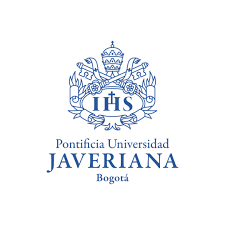
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

### Taller: **Métricas de Rendimiento para Modelos de Clasificación con PySpark**

Autor: Ricardo Hurtado

Fecha: 19/05/2025

**Objetivo**: Evaluar modelo de clasificación MLlib

- La clasificación se utiliza para clasificar datos en etiquetas o clases predefinidas. Para evaluar el rendimiento de un modelo de clasificación se suelen utilizar métricas como: accuracy, precision, recall, F1 score y la matriz de confusión. Estas métricas son útiles para evaluar lo bien que el modelo distingue entre clases, especialmente en casos de conjuntos de datos desequilibrados. Al conocer los puntos fuertes y débiles de cada métrica, se podrá seleccionar la más adecuada para un problema de clasificación determinado.

- MLlib de PySpark, se presenta un conjunto de clases: BinaryClassificationEvaluator, MulticlassificationEvaluator, y RegressionEvaluator-diseñadas para evaluar el rendimiento de los modelos de aprendizaje automático calculando métricas específicas a partir de predicciones y etiquetas verdaderas. Se utilizan para evaluar modelos entrenados con estimadores como RandomForestClassifier o GBTRegressor, tomando un DataFrame con valores predichos y reales para producir una única puntuación de rendimiento. Ejecutados a través de una SparkSession, aprovechan los ejecutores de Spark para la computación distribuida, lo que los hace ideales para **BIG DATA** de fuentes como archivos CSV o Parquet. Se integran en herramientas de ajuste como CrossValidator y TrainValidationSplit, ofreciendo una solución escalable para la evaluación de modelos.
____________________________________________________

In [4]:
#Sesion de Spark
from pyspark.sql.functions import col, when, avg
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Taller_Metricas").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")
spark

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.-Cargar DataFrame Spark:**
- Enlace de datos: https://github.com/corredor-john/ExploratoryDataAnalisys/blob/main/Varios/heart_taller_eval_PySpark.csv


In [5]:
from pyspark import SparkFiles
df00 = spark.read.csv(("/content/drive/MyDrive/Colab Notebooks/EXTRA/Prosesamiento datos Datasets/heart_taller_eval_PySpark.csv"),inferSchema=True, header=True)
df00.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

**3.- Revisión de Datos Nulos o Imposibles:**

In [6]:
from pyspark.sql.functions import *

df00.select([count(when(col(c).contains('None') |
col(c).contains('NULL') |
(col(c) == '' ) |
col(c).isNull() | isnan(c), c )).alias(c)
for c in df00.columns]).show()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



no se hayan datos nulos

**4.- Relación entre las variables**
- Escriba algunas apreciaciones de las relaciones


<Axes: >

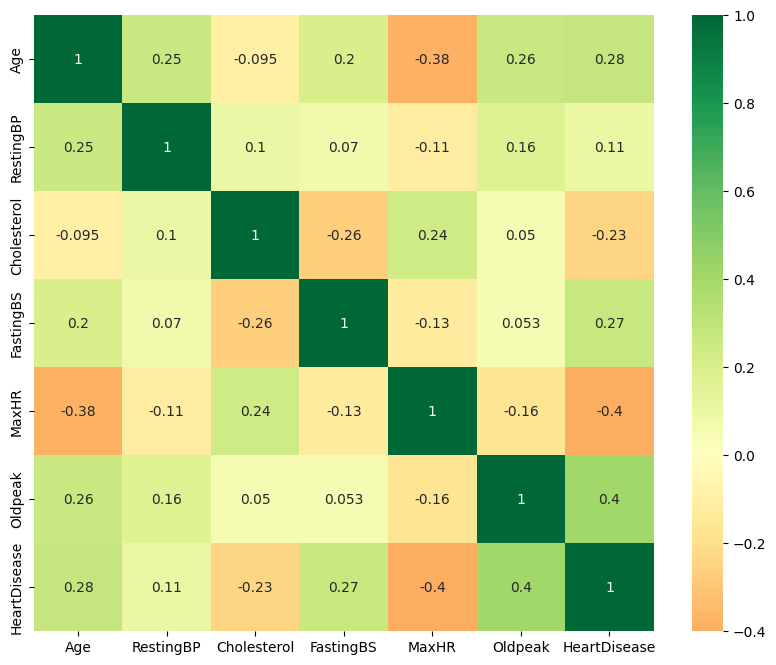

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize =(10,8))
vista_pandas = df00.toPandas()
sns.heatmap(vista_pandas.select_dtypes(np.number).corr(), annot=True, center=0, cmap ='RdYlGn')

Oldpeak (0.40), tiene correlación positiva moderada. A mayor Oldpeak, mayor probabilidad de enfermedad cardíaca. FastingBS (0.27) y Age (0.28) también muestran relaciones positivas, aunque más débiles.  En el caso de la edad esto nos muestra que a mayor edad mas probabbilidad de que haya problemas de corazon. tambien tenemos una relacion negativa fuerte MaxHR (-0.40),  que indica que a mayor frecuencia cardíaca máxima alcanzada, menor probabilidad de enfermedad cardíaca.

### Ingeniería de características

**5.- Consulte los tipos de datos**



```
dfBog.dtypes
```

In [8]:
df00.dtypes

[('Age', 'int'),
 ('Sex', 'string'),
 ('ChestPainType', 'string'),
 ('RestingBP', 'int'),
 ('Cholesterol', 'int'),
 ('FastingBS', 'int'),
 ('RestingECG', 'string'),
 ('MaxHR', 'int'),
 ('ExerciseAngina', 'string'),
 ('Oldpeak', 'double'),
 ('ST_Slope', 'string'),
 ('HeartDisease', 'int')]

**6.- Funciones para datos ETIQUETAS o categorías a Numéricos**
- 6.1: Imprimir todas las columnas de Etiquetas del tipo string


In [9]:
df00.select('Sex').distinct().show()
df00.select('ChestPainType').distinct().show()
df00.select('RestingECG').distinct().show()
df00.select('ExerciseAngina').distinct().show()
df00.select('ST_Slope').distinct().show()

+---+
|Sex|
+---+
|  F|
|  M|
+---+

+-------------+
|ChestPainType|
+-------------+
|          NAP|
|          ATA|
|           TA|
|          ASY|
+-------------+

+----------+
|RestingECG|
+----------+
|       LVH|
|    Normal|
|        ST|
+----------+

+--------------+
|ExerciseAngina|
+--------------+
|             Y|
|             N|
+--------------+

+--------+
|ST_Slope|
+--------+
|    Flat|
|      Up|
|    Down|
+--------+



- 6.2: Usar la función para cambiar a dato numéricos



In [10]:
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when

def fun_Etiquetas(df):
    trans_df = df.select("*",(when(df.ExerciseAngina=='Y', 1).otherwise(0)).alias('yes_exercise_angina')
                 ,(when(df.ChestPainType=='ATA', 1).otherwise(0)).alias('ata_chest_pain_type')
              ,(when(df.ChestPainType=='ASY', 1).otherwise(0)).alias('asy_chest_pain_type')
              ,(when(df.ST_Slope=='Up', 1).otherwise(0)).alias('up_st_slope')
              ,(when(df.Sex=='F', 1).otherwise(0)).alias('f_sex')
              ,(when(df.RestingECG=='ST', 1).otherwise(0)).alias('st_resting_ecg')
                 ).drop('ExerciseAngina','ChestPainType', 'ST_Slope', 'Sex', 'RestingECG').withColumnRenamed("HeartDisease", 'label')

    features_list = trans_df.columns
    print(features_list)
    features_list.remove('label')
    assembler = VectorAssembler(inputCols=features_list,outputCol='features')
    vector_trans_df = assembler.transform(trans_df).select('features','label')

    return vector_trans_df, trans_df


vector_trans_df, trans_df = fun_Etiquetas(df00)

['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'label', 'yes_exercise_angina', 'ata_chest_pain_type', 'asy_chest_pain_type', 'up_st_slope', 'f_sex', 'st_resting_ecg']


6.3.- Imprimir 5 primeros valores de la transformación a vectores

```
vector_trans_df.show(n, False)

```

In [11]:
vector_trans_df.show(5, False)

+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|(12,[0,1,2,4,7,9],[40.0,140.0,289.0,172.0,1.0,1.0])     |0    |
|(12,[0,1,2,4,5,10],[49.0,160.0,180.0,156.0,1.0,1.0])    |1    |
|[37.0,130.0,283.0,0.0,98.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0] |0    |
|[48.0,138.0,214.0,0.0,108.0,1.5,1.0,0.0,1.0,0.0,1.0,0.0]|1    |
|(12,[0,1,2,4,9],[54.0,150.0,195.0,122.0,1.0])           |0    |
+--------------------------------------------------------+-----+
only showing top 5 rows



**7.- División de Datos Entrenamiento y Prueba**



In [12]:
train, test = vector_trans_df.randomSplit([0.7,0.3], seed = 13)

**8.- Consulta: Escriba sus apreciaciones sobre el balanceo de los datos, en Entrenamiento y en los de Prueba**




In [13]:
total=float(train.select("label").count())
Positivos=train.select("label").where('label == 1').count()
porcentaje=(float(Positivos)/float(total))*100
total=float(train.select("label").count())
Positivos=train.select("label").where('label == 1').count()
porcentaje=(float(Positivos)/float(total))*100
Negativos=float(total - Positivos)
print('Cantidad de positivos {}'.format(Positivos))
print('Percentaje de positivos {}'.format(porcentaje))

Cantidad de positivos 359
Percentaje de positivos 53.9039039039039


El porcentaje de positivos es cercano al 50%, lo que indica que las clases están equilibradas. eso es nesesario porque asi el modelo no va a predecir una clase mas que la otra solo por mayoria de casos, sino buscando patrones.

## Modelado

**9.- Modelo a seguir es de árboles de decisiones**


In [14]:
from pyspark.ml.classification import DecisionTreeClassifier

parametros = {'maxDepth':4}

clasificador = DecisionTreeClassifier(**parametros, seed= 13)

modeloArboles = clasificador.fit(train)

**10.- Predicciones sobre los datos de prueba**



In [56]:
prediccionesPrueba = modeloArboles.transform(test)
prediccionesPrueba.show(2, False)

+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|features                                           |label|rawPrediction|probability                            |prediction|
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
|(12,[0,1,2,3,4],[74.0,140.0,237.0,1.0,94.0])       |1    |[9.0,36.0]   |[0.2,0.8]                              |1.0       |
|(12,[0,1,2,3,4,5],[52.0,152.0,298.0,1.0,178.0,1.2])|0    |[6.0,15.0]   |[0.2857142857142857,0.7142857142857143]|1.0       |
+---------------------------------------------------+-----+-------------+---------------------------------------+----------+
only showing top 2 rows



##**11.- Evaluación de Modelo de Clasificación**



In [57]:
matrzC_prueba = prediccionesPrueba.crosstab("prediction", "label")
matrzC_prueba = matrzC_prueba.toPandas()
matrzC_prueba.sort_values(by = ['prediction_label'])

,prediction_label,0,1
1,0.0,82,27
0,1.0,21,122



- Imprima las métricas a continuación en (0.00%), escriba sus apreciaciones


In [17]:
TP = matrzC_prueba["1"][0]
FP = matrzC_prueba["0"][0]
TN = matrzC_prueba["0"][1]
FN = matrzC_prueba["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)     # Exactitud global del modelo
Sensitivity = TP/(TP+FN)             # Recall o Tasa de verdaderos positivos
Specificity = TN/(TN+FP)             # Tasa de verdaderos negativos
Precision = TP/(TP+FP)               # Precisión (positivos predichos que son correctos)

print(f"Accuracy = {np.round(Accuracy,2)*100}%")
print(f"Sensitivity = {np.round(Sensitivity,2)*100}%")
print(f"Specificity = {np.round(Specificity,2)*100}%")
print(f"Precision = {np.round(Precision,2)*100}%")

Accuracy = 81.0%
Sensitivity = 82.0%
Specificity = 80.0%
Precision = 85.0%


In [58]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

auc = evaluator.evaluate(prediccionesPrueba)
print(f"Área bajo la curva ROC (AUC): {auc:.4f}")


Área bajo la curva ROC (AUC): 0.8710


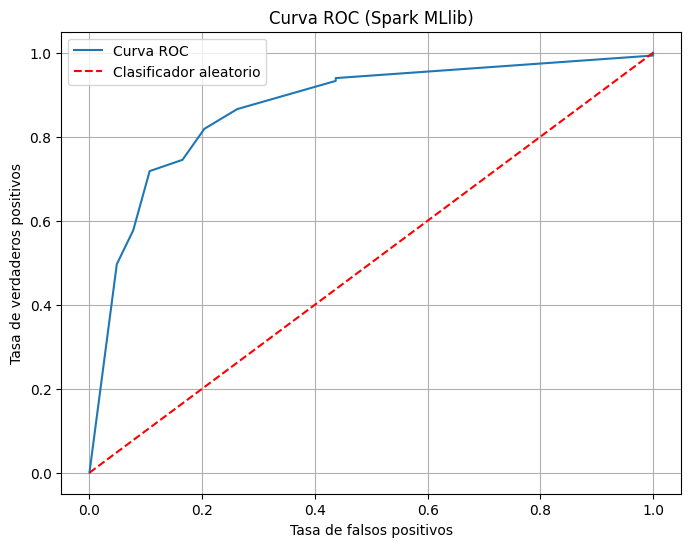

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0, 1], [0, 1], 'r--', label="Clasificador aleatorio")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC (Spark MLlib)")
plt.legend()
plt.grid(True)
plt.show()


**12.- Terminar sesión SPARK**

```
spark.stop()
```

In [ ]:
#spark.stop()

## **12.- Conclusiones: redacte sus conclusiones por cada paso y conclusión final de Cierre**

se puede observar que el modelo tuvo una Exactitud(Accuracy) de 81% esto nos dice que fue un modelo de alta exactitud puesto que fue cercana al 100%, es decir que el modelo predijo correctamente con exactitud un 81% de los valores. lo que indica que logra predecir correctamente más de 8 de cada 10 casos. Este resultado sugiere un desempeño alto en su tarea de clasificar valores. La sensibilidad refleja que el modelo identifica correctamente el 82% de los casos positivos reales. Con una especificidad del 80.0%, el modelo también es competente en identificar correctamente los casos negativos, lo que ayuda a evitar falsos positivos. La precisión del 85.0% indica que, entre todas las instancias que el modelo clasificó como positivas, el 85% eran realmente positivas. El valor del Área Bajo la Curva (AUC) es de 0.8710, lo cual representa una excelente capacidad del modelo para discriminar entre las clases. Cuanto más cerca de 1, mejor es el modelo, y un AUC por encima de 0.85 se considera muy bueno.

En conjunto, los resultados indican que el modelo tiene un desempeño equilibrado y eficaz tanto en la detección de positivos como de negativos. teniendo  alta precisión, buena sensibilidad, especificidad y un AUC superior a 0.87 demuestra que el modelo fue entrenado correctamente y puede ser usado para poder predecir correctamente si un paciente podria llegar a tener una Enfermedad Cardiaca.
